In [1]:
import librosa
from utils import *
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.model_selection import KFold

import os
import glob 
import pandas as pd
import IPython.display as ipd
import plotly.express as px
import scipy.io.wavfile
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/home/srushti/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-09-26 09:27:13.172425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 09:27:14.239466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
RAV = 'Ravdess/'
dir_list = os.listdir(RAV)

emotion = []
gender = []
path = []
feature = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)
        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender'], axis=1)
RAV_df.labels.value_counts()

labels
female_neutral     144
male_neutral       144
female_sad          96
female_fear         96
female_happy        96
female_angry        96
female_surprise     96
female_disgust      96
male_disgust        96
male_happy          96
male_fear           96
male_angry          96
male_sad            96
male_surprise       96
Name: count, dtype: int64

X, Y = [], []
for path, emotion in zip(RAV_df.path, RAV_df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features1.csv', index=False)

In [3]:
Features = pd.read_csv('features1.csv')

In [4]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [5]:
X.shape

(4320, 162)

In [6]:
Y.shape

(4320,)

In [7]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [8]:
Y.shape

(4320, 7)

In [9]:
Y[2000]

array([0., 0., 0., 0., 1., 0., 0.])

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 7), (1080, 162), (1080, 7))

In [11]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [12]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 7), (1080, 162), (1080, 7))

In [13]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 7), (1080, 162, 1), (1080, 7))

In [14]:
def createModel():
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.2))
    
    model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    
    model.add(Flatten())
    model.add(Dense(units=16, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(units=7, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

##model.summary()

In [15]:
mymodel = createModel()

In [16]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
history=mymodel.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.1993 - loss: 1.9164 - val_accuracy: 0.2769 - val_loss: 1.8522 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2669 - loss: 1.8458 - val_accuracy: 0.3194 - val_loss: 1.7537 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.3151 - loss: 1.7621 - val_accuracy: 0.3315 - val_loss: 1.6976 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2848 - loss: 1.7748 - val_accuracy: 0.3556 - val_loss: 1.6698 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3247 - loss: 1.6930 - val_accuracy: 0.3741 - val_loss: 1.6409 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3223 - loss: 1.6848 - val_accuracy: 0.3694 - val_loss: 1.6290 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.3411 - loss: 1.6641 - val_acc

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6234 - loss: 1.1133
Accuracy of our model on test data :  61.11111044883728 %


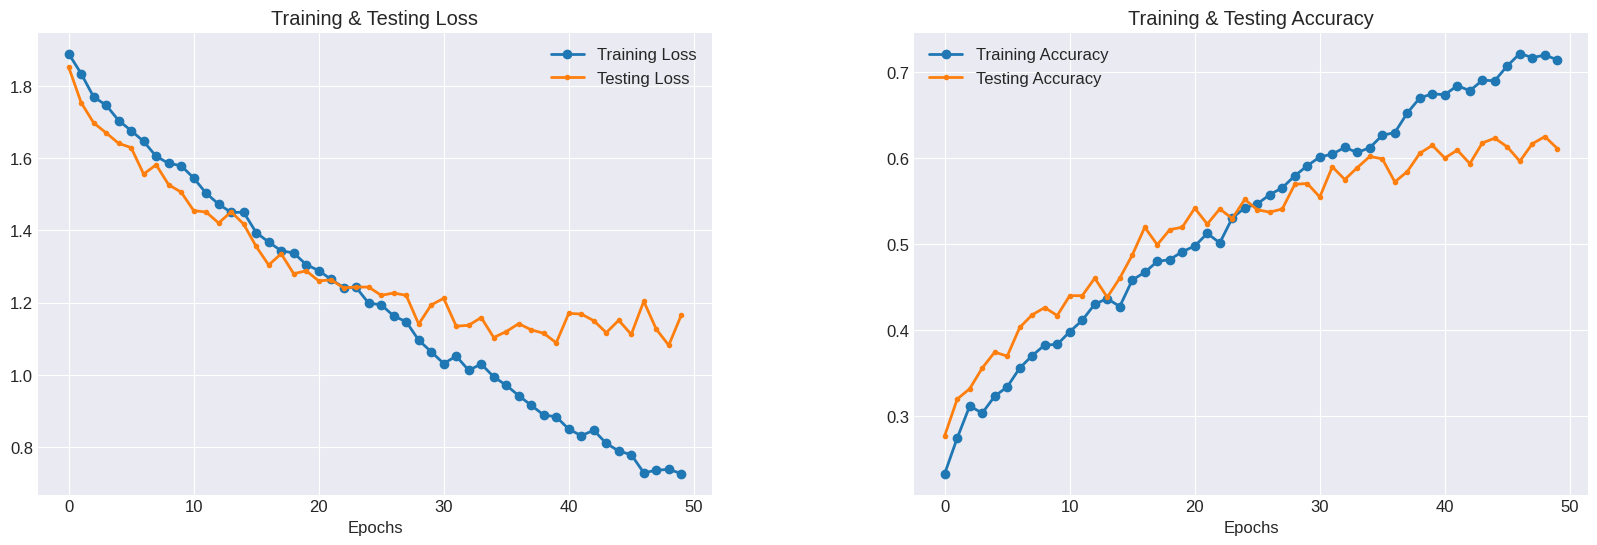

In [17]:
print("Accuracy of our model on test data : " , mymodel.evaluate(x_test,y_test)[1]*100 , "%")

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 12})
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss',marker='o', linewidth=2)
ax[0].plot(epochs , test_loss , label = 'Testing Loss',marker='.', linewidth=2)
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy',marker='o', linewidth=2)
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy',marker='.', linewidth=2)
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.subplots_adjust(wspace=0.3)
plt.show()

In [18]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [19]:
pred_test = mymodel.predict(x_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [20]:
x_test.shape

(1080, 162, 1)

In [21]:
pe = encoder.inverse_transform(pred_test)

In [22]:
qe = encoder.inverse_transform(y_test)

In [23]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = pe.flatten()
df['Actual Labels'] = qe.flatten()

display(df.head(10))

,Predicted Labels,Actual Labels
0,neutral,neutral
1,sad,happy
2,surprise,surprise
3,neutral,neutral
4,neutral,neutral
5,sad,fear
6,angry,angry
7,fear,fear
8,happy,happy
9,happy,fear


In [24]:
mymodel.save('srushti.keras')